### Impoting libraries:

In [1]:
import os
import random
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm 
import random
import matplotlib.pyplot as plt
import json
import yaml

import shutil

In [2]:
%matplotlib inline

In [3]:
# datasetname = 'SCARA-Robot'
datasetname = 'MDX-Robot-Demo'
BASEPATH = os.path.abspath(datasetname)
BASEPATH

'd:\\robot_pose\\MDX-Robot-Demo'

In [ ]:
!mkdir $BASEPATH\\dataset
!move $BASEPATH\*.jpeg $BASEPATH\dataset

���� ���͸� �Ǵ� ���� d:\robot_pose\MDX-Robot-Demo\\dataset��(��) �̹� �ֽ��ϴ�.
�ߺ��Ǵ� ���� �̸��� �ְų� ������
ã�� �� �����ϴ�.


## Process COCO-Annotation

In [4]:
with open(f"{BASEPATH}\.exports\coco-1752453537.2356586.json") as f:
    data = json.load(f)

In [5]:
annotations = data['annotations']
images = data['images']
keypoint_cat_id = 3
bbox_cat_id = 2
datapath = os.path.join(BASEPATH, "dataset\\")
class_id = 0

In [6]:
def find_dict_by_keys(data, target_id, target_category_id):
    for item in data:
        if item.get('image_id') == target_id and item.get('category_id') == target_category_id:
            return item
    return None

def normalize_annotations(keypoints, bbox, image_width, image_height):
    """
    Normalize keypoints and bounding box coordinates to [0, 1] range.

    Parameters:
    - keypoints: list of [px_1, py_1, visible_1, ..., px_n, py_n, visible_n]
    - bbox: list of [x, y, width, height]
    - image_width: width of the image
    - image_height: height of the image

    Returns:
    - normalized_keypoints: list with normalized x and y (visibility unchanged)
    - normalized_bbox: [x/w, y/h, width/w, height/h]
    """

    normalized_keypoints = []
    for i in range(0, len(keypoints), 3):
        x = keypoints[i] / image_width
        y = keypoints[i + 1] / image_height
        v = keypoints[i + 2]  # visibility stays the same
        normalized_keypoints.extend([x, y, v])

    x, y, width, height = bbox
    # width = x2 - x
    # height = y2 - y
    normalized_bbox = [
        x / image_width,
        y / image_height,
        width / image_width,
        height / image_height
    ]

    return normalized_keypoints, normalized_bbox


In [7]:
pbar = tqdm(images)
for image in pbar:
    img_id = image['id']
    file_name = image['file_name']
    image_width = image['width']
    image_height = image['height']

    bbox_annot = find_dict_by_keys(annotations, img_id, bbox_cat_id)
    keypoint_annot = find_dict_by_keys(annotations, img_id, keypoint_cat_id)
    if bbox_annot is None or keypoint_annot is None:
        continue
    bbox = bbox_annot['bbox'] # min_x, min_y, bw, bh
    # change to x_center, y_center
    bbox[0] += bbox[2]/2
    bbox[1] += bbox[3]/2
    keypoints = keypoint_annot['keypoints']
    
    # Normalize
    keypoints_n, bbox_n = normalize_annotations(keypoints, bbox, image_width, image_height)
    merged = [class_id]
    merged.extend(bbox_n)
    merged.extend(keypoints_n)
    # print()
    dt = str(merged)[1:-1].replace(",","")
    fname = file_name.split(".")[-2]
    with open(f'{datapath}{fname}.txt', 'w') as fp:
        fp.writelines(dt)
    
    # break
    pbar.set_description(f"Processing: {file_name}")

  0%|          | 0/269 [00:00<?, ?it/s]

Processing: Frame-800.jpeg: 100%|██████████| 269/269 [00:00<00:00, 426.18it/s] 


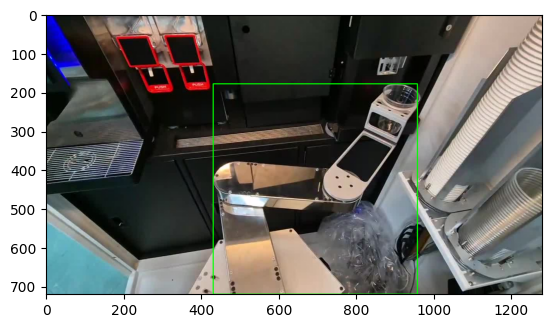

In [8]:
img = cv2.imread(f"{datapath}{file_name}")

h, w, _ = img.shape
x, y, bw, bh = bbox_n
# Convert YOLO normalized coordinates to pixel values
x1, y1 = int((x - bw / 2) * w), int((y - bh / 2) * h)
x2, y2 = int((x + bw / 2) * w), int((y + bh / 2) * h)
cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# x, y, bw, bh = list(map(int, bbox))
# x1 = int(x - bw/2)
# y1 = int(y - bh/2)

# x2 = int(x + bw/2)
# y2 = int(y + bh/2)

# cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### EDA:

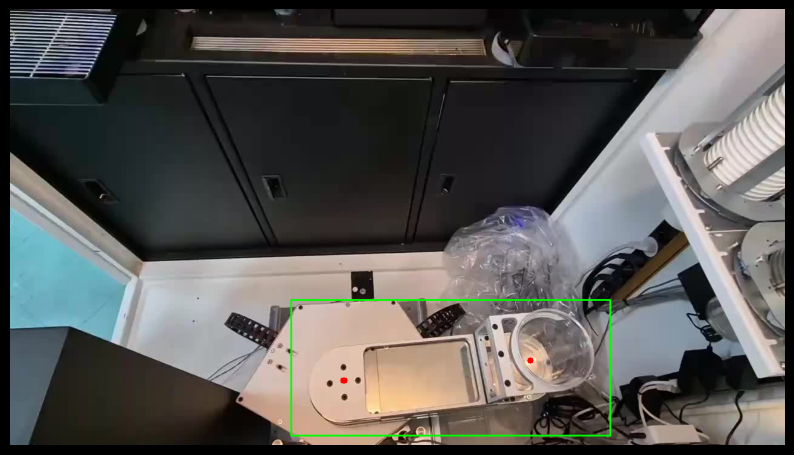

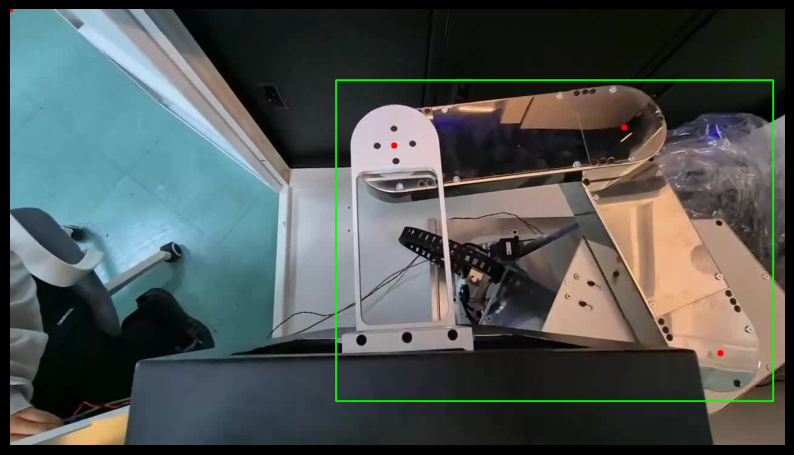

In [9]:
data_folder = datapath

# Function to parse YOLO pose format annotation
def parse_yolo_pose(annotation_path):
    with open(annotation_path, 'r') as file:
        line = file.readline().strip().split()
        data = list(map(float, line[1:]))  # Skip class index
        bbox = data[:4]  # Bounding box format: [x, y, width, height]
        keypoints = data[4:]  # Keypoints format: [px1, py1, px2, py2, ..., pxn, pyn]
    return bbox, keypoints

# Function to draw bounding box and keypoints on an image
def draw_annotations(image, bbox, keypoints):
    h, w, _ = image.shape
    x, y, bw, bh = bbox
    # Convert YOLO normalized coordinates to pixel values
    x1, y1 = int((x - bw / 2) * w), int((y - bh / 2) * h)
    x2, y2 = int((x + bw / 2) * w), int((y + bh / 2) * h)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Draw keypoints
    for i in range(0, len(keypoints), 3):
        kp_x = int(keypoints[i] * w)
        kp_y = int(keypoints[i+1] * h)
        cv2.circle(image, (kp_x, kp_y), 5, (0, 0, 255), -1)
    return image
# Function to display images one by one with black background
def display_images_one_by_one(images):
    for img in images:
        fig, ax = plt.subplots(figsize=(10, 10))
        fig.patch.set_facecolor('black')  # Set background color to black
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_facecolor('black')  # Set subplot's background color to black
        plt.show()

# Main function to select images and plot annotations one by one
def plot_random_annotations(num_images=4):
    # Get all image file paths
    image_files = [f for f in os.listdir(data_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(image_files, num_images)
    
    annotated_images = []
    for image_file in selected_images:
        # Load the image
        image_path = os.path.join(data_folder, image_file)
        image = cv2.imread(image_path)
        
        # Load corresponding annotation file
        annotation_path = os.path.join(data_folder, image_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))
        if os.path.exists(annotation_path):
            bbox, keypoints = parse_yolo_pose(annotation_path)
            # Draw bounding box and keypoints on the image
            annotated_image = draw_annotations(image, bbox, keypoints)
            annotated_images.append(annotated_image)
    
    # Display images one by one
    display_images_one_by_one(annotated_images)

# Run the function with the desired number of images
plot_random_annotations(num_images=4)

### Creating train_val split and dataset.yaml file:

In [43]:
datapath

'd:\\robot_pose\\MDX-Robot-Demo\\dataset\\'

In [42]:
from glob import glob

for path in glob(os.path.join(datapath,"*.txt")):
    print(path)

In [10]:
### to create dataset.yaml file
def createdataYaml(
    train_path, 
    val_path, 
    outdir="D:\\robot_pose\\",  
    class_names=["tiger"], 
    kpt_shape=[12, 2],  ### number of keypoints, number of dims: 2 for x,y or 3 for x,y,visible
    flip_idx=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] ### 11 number of keypoints
):
    data = {
        "train": train_path,  # train images (relative to 'path')
        "val": val_path,      # val images (relative to 'path')
        "kpt_shape": kpt_shape,  # number of keypoints and dimensions
        "flip_idx": flip_idx,    # indices for keypoints flip mapping
        "names": {i: name for i, name in enumerate(class_names)}  # class names with indices
    }

    # Prepare the data for YAML to match the desired format
    yaml_data = {
        "train": data["train"],
        "val": data["val"],
        "kpt_shape": data["kpt_shape"],
        "flip_idx": data["flip_idx"],
        "names": data["names"]
    }
    def write_yaml_to_file(py_obj, filename):
        with open(f'{filename}.yaml', 'w') as f:
            yaml.dump(py_obj, f, sort_keys=False)
        print(f'Written to file {filename}.yaml successfully')

    datasetyamloutdir = os.path.join(outdir, "dataset")
    write_yaml_to_file(yaml_data, datasetyamloutdir)

'''
Split the dataset into train and test and creates the train.txt and test.tx with
the respective path of the images in each folder
'''
def train_test_split(path, class_names=[], neg_path=None, split=0.2, outdir="D:\\robot_pose\\", kpt_shape = None, flip_idx = None):
    print("------ PROCESS STARTED -------")
    
    # Supported image extensions
    valid_extensions = ('.jpeg', '.jpg', '.png', '.bmp')
    
    # Get list of files without extension and remove duplicates
    files = list(set([os.path.splitext(name)[0] for name in os.listdir(path) if name.endswith(valid_extensions)]))

    print(f"--- This folder has a total number of {len(files)} images---")
    random.seed(42)
    random.shuffle(files)

    test_size = int(len(files) * split)
    train_size = len(files) - test_size

    # Paths for train and validation folders (writing to /kaggle/working)
    base_output_path = os.path.join(outdir, 'yolo_split')
    train_path_img = os.path.join(base_output_path, 'train', 'images')
    train_path_label = os.path.join(base_output_path, 'train', 'labels')
    val_path_img = os.path.join(base_output_path, 'val', 'images')
    val_path_label = os.path.join(base_output_path, 'val', 'labels')
    
    data_yaml_train = os.path.join(base_output_path, 'train')
    data_yaml_val = os.path.join(base_output_path, 'val')


    # Create directories if they don't exist
    os.makedirs(train_path_img, exist_ok=True)
    os.makedirs(train_path_label, exist_ok=True)
    os.makedirs(val_path_img, exist_ok=True)
    os.makedirs(val_path_label, exist_ok=True)

    # Copy files to training folder
    for filex in tqdm(files[:train_size]):
        if filex == 'classes':
            continue
        for ext in valid_extensions:
            if os.path.exists(os.path.join(path, filex + ext)) and os.path.exists(os.path.join(path, filex + '.txt')):
                shutil.copy2(os.path.join(path, filex + ext), os.path.join(train_path_img, filex + ext))
                shutil.copy2(os.path.join(path, filex + '.txt'), os.path.join(train_path_label, filex + '.txt'))
                break

    print(f"------ Training data created with 80% split: {len(files[:train_size])} images -------")

    # Handle negative images if neg_path is provided
    if neg_path:
        neg_images = list(set([os.path.splitext(name)[0] for name in os.listdir(neg_path) if name.endswith(valid_extensions)]))
        for filex in tqdm(neg_images):
            for ext in valid_extensions:
                if os.path.exists(os.path.join(neg_path, filex + ext)):
                    shutil.copy2(os.path.join(neg_path, filex + ext), os.path.join(train_path_img, filex + ext))
                    break

        print(f"------ Total {len(neg_images)} negative images added to the training data -------")
        print(f"------ TOTAL Training data created with {len(files[:train_size]) + len(neg_images)} images -------")

    # Copy files to validation folder
    for filex in tqdm(files[train_size:]):
        if filex == 'classes':
            continue
        for ext in valid_extensions:
            if os.path.exists(os.path.join(path, filex + ext)) and  os.path.exists(os.path.join(path, filex + '.txt')):
                shutil.copy2(os.path.join(path, filex + ext), os.path.join(val_path_img, filex + ext))
                shutil.copy2(os.path.join(path, filex + '.txt'), os.path.join(val_path_label, filex + '.txt'))
                break

    print(f"------ Testing data created with a total of {len(files[train_size:])} images ----------")
    
    # Call the function to create dataset.yaml after splitting
    if kpt_shape is None:
        createdataYaml(train_path=data_yaml_train, val_path=data_yaml_val, outdir=outdir)
    createdataYaml(train_path=data_yaml_train, val_path=data_yaml_val, class_names=class_names, outdir=outdir, kpt_shape=kpt_shape, flip_idx=flip_idx)
    print("------ TASK COMPLETED -------")


In [11]:
### for label_tag
class_names=["robot"], 
kpt_shape=[4, 3],  ### number of keypoints, number of dims: 2 for x,y or 3 for x,y,visible
flip_idx=[1, 2, 3, 4] ### 11 number of keypoints
train_test_split(datapath, class_names=class_names, split=0.2, outdir=BASEPATH, flip_idx=flip_idx, kpt_shape=kpt_shape)

------ PROCESS STARTED -------
--- This folder has a total number of 2040 images---


  0%|          | 0/1632 [00:00<?, ?it/s]

100%|██████████| 1632/1632 [00:03<00:00, 539.22it/s]


------ Training data created with 80% split: 1632 images -------


100%|██████████| 408/408 [00:00<00:00, 525.03it/s]

------ Testing data created with a total of 408 images ----------
Written to file d:\robot_pose\MDX-Robot-Demo\dataset.yaml successfully
------ TASK COMPLETED -------


In [17]:
# !rm -rf yolo_split

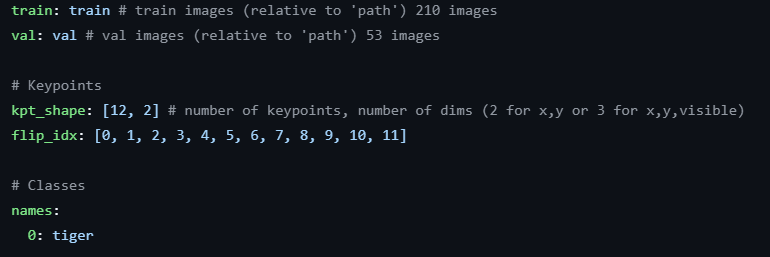

In [13]:
import yaml

def read_and_display_yaml(file_path):
    """Reads a YAML file and prints its contents."""
    with open(file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)
    
    
    # Display YAML content
    print(yaml.dump(yaml_content, default_flow_style=False))
    
read_and_display_yaml(f"{BASEPATH}\dataset.yaml")

flip_idx:
- 1
- 2
- 3
- 4
kpt_shape:
- 4
- 3
names:
  0: robot
train: d:\robot_pose\MDX-Robot-Demo\yolo_split\train
val: d:\robot_pose\MDX-Robot-Demo\yolo_split\val



### Installation of ultralytics:

In [ ]:
!pip install ultralytics 

In [ ]:
!pip3 uninstall wandb -y

In [ ]:
!wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n-pose.pt

In [14]:
from ultralytics import YOLO
model = YOLO("yolo11n-pose.pt")

In [15]:
training_name = "robot_pose_training"

### Training:

In [16]:
# Train the model
### check for more arguments: https://docs.ultralytics.com/usage/cfg/#train-settings

results = model.train(data=f"{BASEPATH}\\dataset.yaml", epochs=500, imgsz=480, project= f"{BASEPATH}\\training_backup",
                      name=f"{training_name}", optimizer="AdamW",verbose = True)

Ultralytics 8.3.163  Python-3.11.11 torch-2.7.1+cpu CPU (Intel Xeon E5-2620 v4 2.10GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=d:\robot_pose\MDX-Robot-Demo\dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=500, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=robot_pose_training, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=

train: Scanning D:\robot_pose\MDX-Robot-Demo\yolo_split\train\labels... 215 images, 0 backgrounds, 208 corrupt: 100%|██████████| 215/215 [00:00<00:00, 1456.49it/s]

train: D:\robot_pose\MDX-Robot-Demo\yolo_split\train\images\Frame-1361.jpeg: ignoring corrupt image/label: labels require 17 columns each
train: D:\robot_pose\MDX-Robot-Demo\yolo_split\train\images\Frame-1362.jpeg: ignoring corrupt image/label: labels require 17 columns each
train: D:\robot_pose\MDX-Robot-Demo\yolo_split\train\images\Frame-1363.jpeg: ignoring corrupt image/label: labels require 17 columns each
train: D:\robot_pose\MDX-Robot-Demo\yolo_split\train\images\Frame-1364.jpeg: ignoring corrupt image/label: labels require 17 columns each
train: D:\robot_pose\MDX-Robot-Demo\yolo_split\train\images\Frame-1365.jpeg: ignoring corrupt image/label: labels require 17 columns each
train: D:\robot_pose\MDX-Robot-Demo\yolo_split\train\images\Frame-1366.jpeg: ignoring corrupt image/label: labels require 17 columns each
train: D:\robot_pose\MDX-Robot-Demo\yolo_split\train\images\Frame-1367.jpeg: ignoring corrupt image/label: labels require 17 columns each
train: D:\robot_pose\MDX-Robot-Dem

train: New cache created: D:\robot_pose\MDX-Robot-Demo\yolo_split\train\labels.cache
val: Fast image access  (ping: 0.20.0 ms, read: 100.211.4 MB/s, size: 58.5 KB)


c:\Users\ibotserver\anaconda3\envs\zeroshotExpression\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning D:\robot_pose\MDX-Robot-Demo\yolo_split\val\labels... 51 images, 0 backgrounds, 49 corrupt: 100%|██████████| 51/51 [00:00<00:00, 1381.62it/s]

val: D:\robot_pose\MDX-Robot-Demo\yolo_split\val\images\Frame-1372.jpeg: ignoring corrupt image/label: labels require 17 columns each
val: D:\robot_pose\MDX-Robot-Demo\yolo_split\val\images\Frame-1374.jpeg: ignoring corrupt image/label: labels require 17 columns each
val: D:\robot_pose\MDX-Robot-Demo\yolo_split\val\images\Frame-1379.jpeg: ignoring corrupt image/label: labels require 17 columns each
val: D:\robot_pose\MDX-Robot-Demo\yolo_split\val\images\Frame-1380.jpeg: ignoring corrupt image/label: labels require 17 columns each
val: D:\robot_pose\MDX-Robot-Demo\yolo_split\val\images\Frame-1384.jpeg: ignoring corrupt image/label: labels require 17 columns each
val: D:\robot_pose\MDX-Robot-Demo\yolo_split\val\images\Frame-1388.jpeg: ignoring corrupt image/label: labels require 17 columns each
val: D:\robot_pose\MDX-Robot-Demo\yolo_split\val\images\Frame-1404.jpeg: ignoring corrupt image/label: labels require 17 columns each
val: D:\robot_pose\MDX-Robot-Demo\yolo_split\val\images\Frame-


c:\Users\ibotserver\anaconda3\envs\zeroshotExpression\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to d:\robot_pose\MDX-Robot-Demo\training_backup\robot_pose_training\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 0 dataloader workers
Logging results to d:\robot_pose\MDX-Robot-Demo\training_backup\robot_pose_training
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]


IndexError: index 4 is out of bounds for axis 1 with size 4

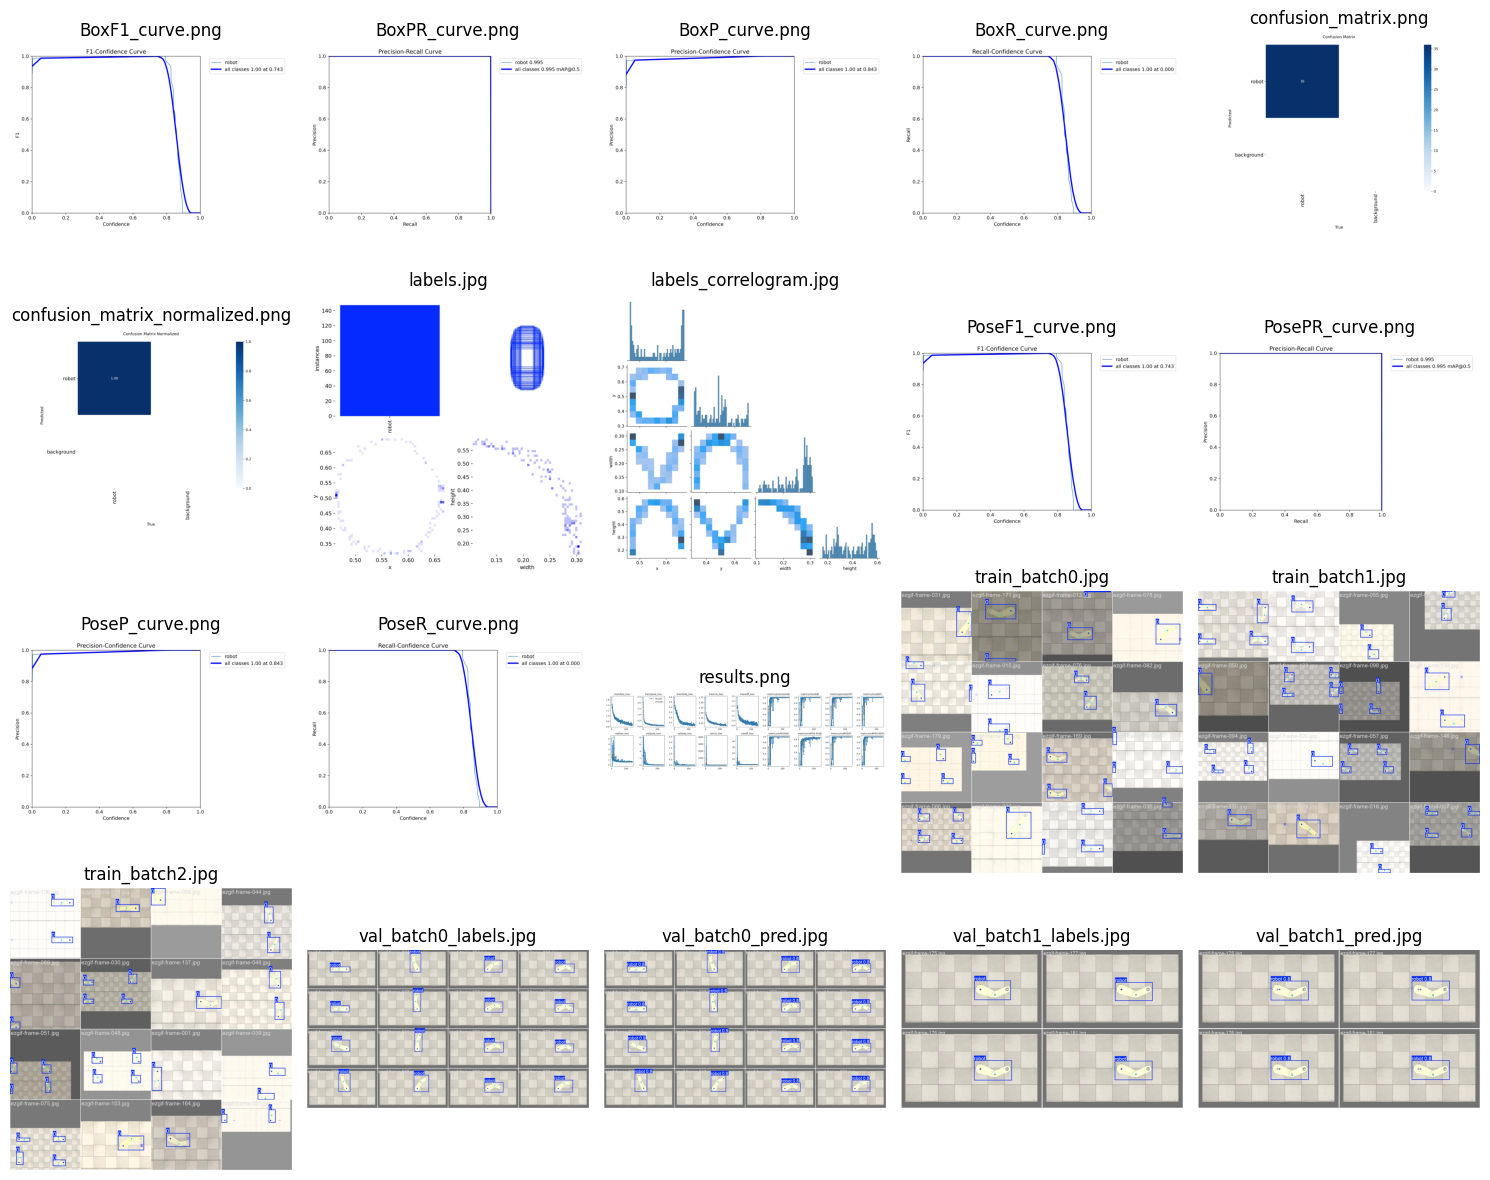

In [ ]:
def display_images_from_folder(folder_path):
    """
    Finds and displays all .jpg, .png, and .jpeg images from a specified folder.
    """
    # Supported image extensions
    valid_extensions = ('.jpg', '.jpeg', '.png')
    
    # List to store images
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]

    if not image_files:
        print("No valid images found in the specified folder.")
        return

    # Plotting images
    plt.figure(figsize=(15, 15))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(5, 5, i+1)  # Adjust the grid size (5, 5) as needed
        plt.imshow(image_rgb)
        plt.title(image_file)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
display_images_from_folder(f"{BASEPATH}\training_backup\robot_pose_training")

### Inferencing:


image 1/1 d:\robot_pose\SCARA-Robot\yolo_split\val\images\ezgif-frame-060.jpg: 256x480 1 robot, 97.3ms
Speed: 2.7ms preprocess, 97.3ms inference, 2.5ms postprocess per image at shape (1, 3, 256, 480)

image 1/1 d:\robot_pose\SCARA-Robot\yolo_split\val\images\ezgif-frame-124.jpg: 256x480 1 robot, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 480)

image 1/1 d:\robot_pose\SCARA-Robot\yolo_split\val\images\ezgif-frame-034.jpg: 256x480 1 robot, 50.5ms
Speed: 1.7ms preprocess, 50.5ms inference, 2.6ms postprocess per image at shape (1, 3, 256, 480)

image 1/1 d:\robot_pose\SCARA-Robot\yolo_split\val\images\ezgif-frame-064.jpg: 256x480 1 robot, 56.7ms
Speed: 1.9ms preprocess, 56.7ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 480)

image 1/1 d:\robot_pose\SCARA-Robot\yolo_split\val\images\ezgif-frame-058.jpg: 256x480 1 robot, 59.4ms
Speed: 2.1ms preprocess, 59.4ms inference, 2.2ms postprocess per image at shape (1, 3, 256, 

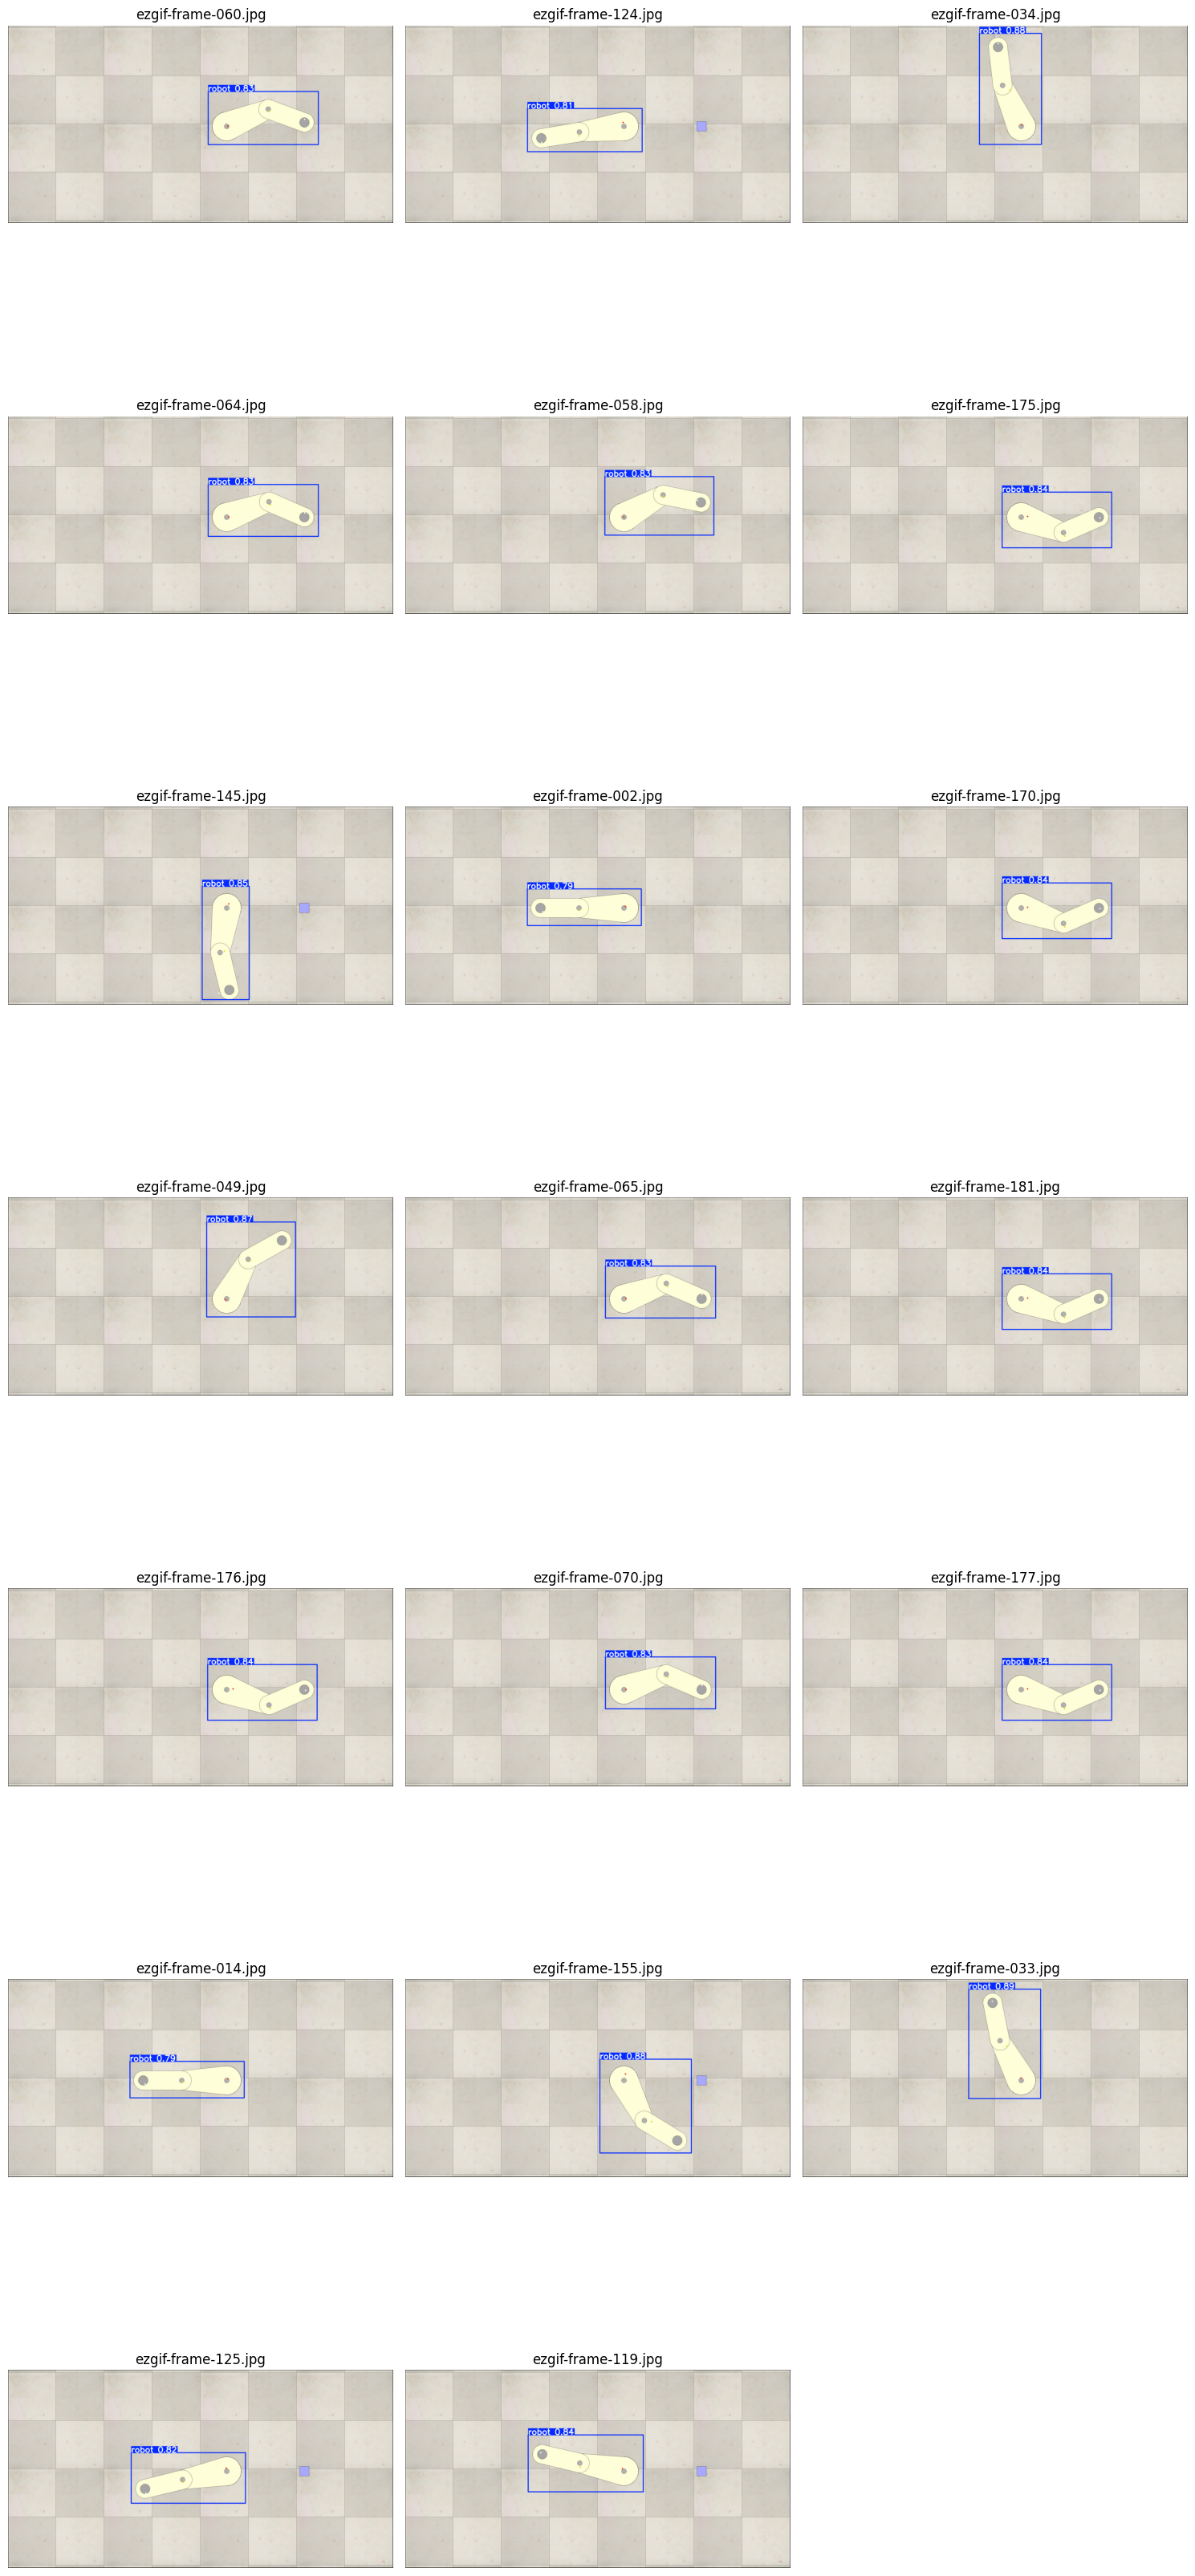

In [18]:
def run_yolov11(image_dir, model_path, total_image=20, output_folder="working/result_vis"):
    # Load the YOLOv11 model
    model = YOLO(model_path)
    
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Loop through all images in the directory
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    
    # Select the specified number of random images or all images if total_image is -1
    if total_image == -1:
        selected_files = image_files
    else:
        selected_files = random.sample(image_files, min(total_image, len(image_files)))

    result_images = []  # List to hold result images

    for image_file in selected_files:
        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)

        # Run YOLOv11 segmentation prediction
        results = model.predict(image_path, conf=0.7, iou=0.7)
        
        # Get the segmented mask and draw it on the image
        result_image = results[0].plot()
        
        # Save the result image in the output folder
        output_image_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_image_path, result_image)
        
        # Append the result image to the list
        result_images.append(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB

    # Display all result images in a grid
    num_images = len(result_images)
    cols = 3  # Number of columns for the grid
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed

    plt.figure(figsize=(15, 5 * rows))  # Adjust the figure size as needed
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(result_images[i])
        plt.axis('off')
        plt.title(selected_files[i])  # Optionally add titles

    plt.tight_layout()
    plt.show()



run_yolov11(f"{BASEPATH}\yolo_split\\val\images", model_path =f"{BASEPATH}\\training_backup\\{training_name}\\weights\\best.pt", output_folder=f"{BASEPATH}\\result_vis")

### Exporting:

In [16]:
# Export the model
model.export(format="onnx")

Ultralytics 8.3.163  Python-3.11.11 torch-2.7.1+cpu CPU (Intel Xeon E5-2620 v4 2.10GHz)
YOLO11n-pose summary (fused): 109 layers, 2,654,326 parameters, 0 gradients, 6.6 GFLOPs

PyTorch: starting from 'D:\robot_pose\SCARA-Robot\training_backup\robot_pose_training\weights\best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 14, 4725) (5.4 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime'] not found, attempting AutoUpdate...
WARNING requirements:  AutoUpdate skipped (offline)

ONNX: starting export with onnx 1.18.0 opset 19...
WARNING ONNX: simplifier failure: No module named 'onnxslim'
ONNX: export success  2.2s, saved as 'D:\robot_pose\SCARA-Robot\training_backup\robot_pose_training\weights\best.onnx' (10.3 MB)

Export complete (2.9s)
Results saved to D:\robot_pose\SCARA-Robot\training_backup\robot_pose_training\weights
Predict:         yolo predict task=pose model=D:\robot_pose\SCARA-Robot\training_backup\robot_pose

'D:\\robot_pose\\SCARA-Robot\\training_backup\\robot_pose_training\\weights\\best.onnx'